In [21]:
import torchvision
import torch

import random
from tools.data_utils import gen_pins, gen_mesh_pins, count_pins, save_data
from tools.plot_utils import visualize_pins, plot_label_pin
from tools.models import DDPM, UNet
import os
import matplotlib.pyplot as plt

In [22]:
def extract_with_ddpm(data, n_steps, store_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load DDPM Model
    ddpm = DDPM(UNet(), n_steps=n_steps, device=device)
    ddpm.load_state_dict(torch.load(store_path, map_location=device))
    
    # Move input to the same device as the model
    x0 = data.unsqueeze(0).unsqueeze(0).to(device)
    n = len(x0)

    # Picking some noise for each of the images in the batch, a timestep, and the respective alpha_bars
    eta = torch.randn_like(x0).to(device)
    t = torch.randint(0, n_steps, (n,)).to(device)

    # Computing the noisy image based on x0 and the time-step (forward process)
    noisy_imgs = ddpm(x0, t, eta)

    # Getting model estimation of noise based on the images and the time-step
    eta_theta, concatenated_feature_map = ddpm.backward(noisy_imgs, t.reshape(n, -1))

    return concatenated_feature_map

In [23]:
def PinMNIST(mnist, n, n_pin_max, r, fixed_pins=True, mesh=False, d=1, store_path = f"./history/ddpm_MNIST.pt", n_steps=200):
    """
    Generate PinMNIST dataset by selecting n unique samples from the original MNIST and adding pins.

    Args:
    original_mnist(dataset): Fixed image dataset to generate all labels
    n (int): Number of unique samples to select from the original MNIST.
    n_pin_max (int): Maximum number of pins to generate for each sample.
    r (int): Radius for counting adjacent ones around each pin.
    fixed_pins (bool): If True, generates a fixed number of pins (n_pin_max) for all samples. If False, generates a random number of pins for each sample.
    mesh (bool): If True, generates pins on a mesh grid based on the 'd' parameter.
    d (int): Spacing between pins when 'mesh' is True.

    Returns:
    images (list): List of binary images.
    pins (list): List of lists of (x, y) coordinate tuples.
    count_images (list): List of count images where counts are the counted values at the pin locations.
    """
    # Load the original MNIST dataset
    # original_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True)

    # Shuffle the original MNIST dataset
    # random.shuffle(original_mnist.data)

    # Initialize lists to store images, pins, and count images
    ddpm_images = []
    pins = []
    labels = []
    # !!!!!!!!!!!!!!!!!! MAKE IT BATCH!! FASTER!!
    for i in range(n):
        # Get the binary image from the shuffled MNIST dataset
        mnist_image = mnist[i]

        # Determine the number of pins to generate
        if mesh:
            pin_locations = gen_mesh_pins(mnist_image, d)
        else:
            if fixed_pins:
                n_pins = n_pin_max
            else:
                n_pins = random.randint(1, n_pin_max)
            # Generate random pins for the binary image
            pin_locations = gen_pins(mnist_image, n_pins)

        # Count the adjacent ones for the pins using the count_pins function
        label = count_pins(mnist_image.numpy(), pin_locations, r)
        mnist_image = extract_with_ddpm(mnist_image, n_steps, store_path)
        mnist_image = mnist_image.squeeze()
        ddpm_images.append(mnist_image)
        pins.append(pin_locations)
        labels.append(label)

    return ddpm_images, pins, labels

In [24]:
original_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True)

# Shuffle the original MNIST dataset
random.shuffle(original_mnist.data)

In [42]:
# Set number of images n and other hyperparameters to generate the PinMNIST dataset by changing the n_pins, fixed_pins, mesh, d and r
n=1000 
n_pins = 10
fixed_pins = True
mesh = False
d = 3
r = 3
seed = 4
random.seed(seed)

# Initialize lists to store images, pins, and count images
images = []

for i in range(n):
    # Get the binary image from the shuffled MNIST dataset
    mnist_image = original_mnist.data[i] / 255.0  # Normalize to [0, 1]
    mnist_image = 2 * (mnist_image - 0.5) # Normalize to [-1, 1]
    images.append(mnist_image)

In [43]:
ddpm_images, pins, labels = PinMNIST(images, n, n_pins, r, mesh=mesh, d=d)

In [45]:
for folder in ["PinMNIST", "PinMNIST_ddpm"]:
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed/"
    else:
        data_folder = f"./data/{folder}/random_fixed{fixed_pins}_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed/"
    os.makedirs(data_folder, exist_ok=True)
    if (folder.split("_")[-1] == "ddpm"):
        save_data(ddpm_images, pins, labels, f"./data/{folder}/", data_folder)
    else:
        save_data(images, pins, labels, f"./data/{folder}/", data_folder)

Data and images have been saved to the CSV and image files.
Data and images have been saved to the CSV and image files.


In [23]:
def plot_all(image, r):
    pin_locations = gen_mesh_pins(image, 1)
    label = count_pins(image.numpy(), pin_locations, r)
    count_image = plot_label_pin(image, pin_locations, label)
    return count_image

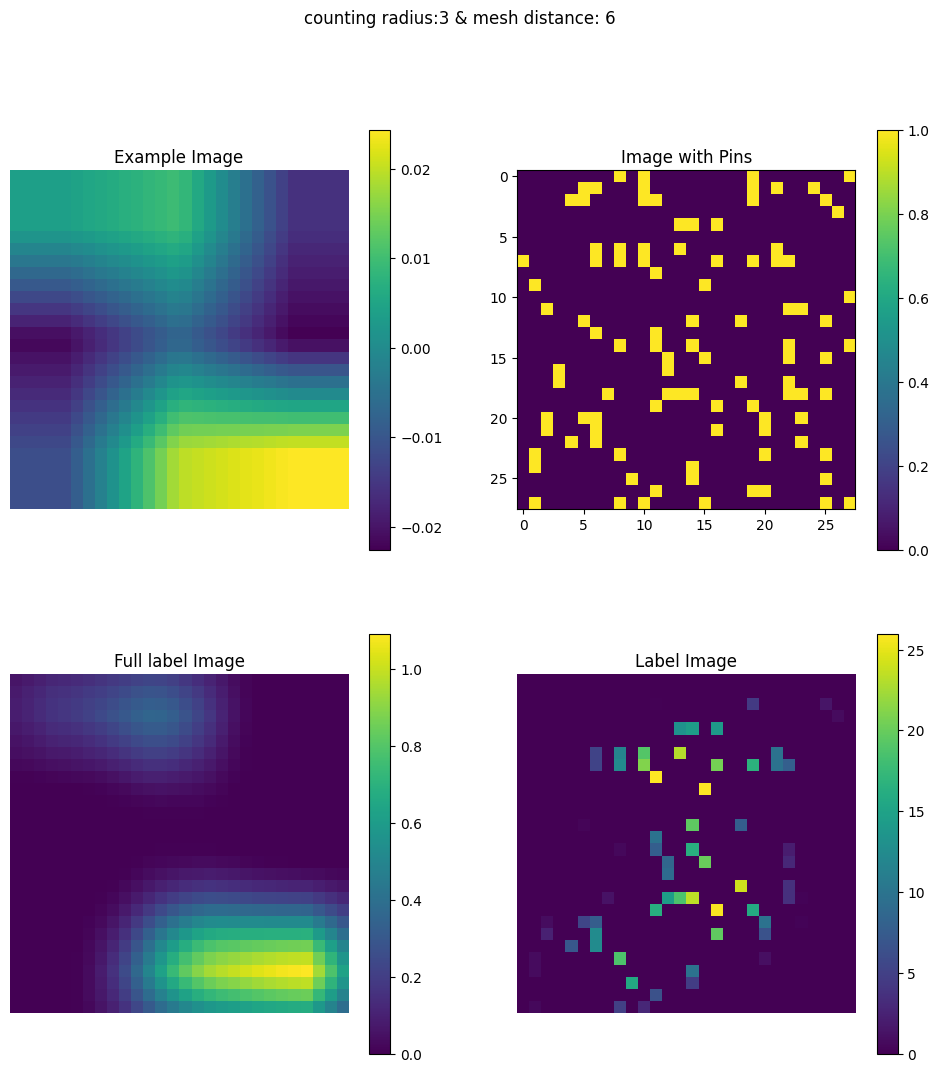

In [24]:
feature_extracted = True 
if feature_extracted:
    example_image = ddpm_images[0][0].detach()
else:
    example_image = images[0].detach()
example_pin, example_label = pins[0], labels[0]


# Create a subplot with three columns
fig, axes = plt.subplots(2, 2, figsize=(12,12))
# Display the original binary image (example_image) in the first column
axes[0,0].imshow(example_image)
cbar1 = plt.colorbar(axes[0,0].images[0], ax=axes[0,0])  # Add colorbar to axes[1]
axes[0,0].set_title("Example Image")
axes[0,0].axis('off')

# Display the image with pins and color mapping in the second column
pins_image = visualize_pins(example_image, example_pin)
axes[0,1].imshow(pins_image)
cbar1 = plt.colorbar(axes[0,1].images[0], ax=axes[0,1])  # Add colorbar to axes[1]
axes[0,1].set_title("Image with Pins")

all_counted_image = plot_all(example_image, r=r)
im1 = axes[1,0].imshow(all_counted_image)
cbar2 = plt.colorbar(im1, ax=axes[1,0])  # Add colorbar to axes[2]
axes[1,0].set_title("Full label Image")
axes[1,0].axis('off')

# Display the count image (count_image) in the third column
count_image = plot_label_pin(example_image, example_pin, example_label)
im = axes[1,1].imshow(count_image)
cbae3 = plt.colorbar(im, ax=axes[1,1])  # Add colorbar to axes[2]
axes[1,1].set_title("Label Image")
axes[1,1].axis('off')

plt.suptitle(f"counting radius:{r} & mesh distance: {d}")
# plt.tight_layout()
fig.savefig(f"{data_folder}sample.jpg")
plt.show()